In [141]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, length, dayofweek, to_timestamp, concat, lit, udf
from pyspark.sql.types import DoubleType, StringType
spark = SparkSession.builder.appName('iteration4').getOrCreate()

In [142]:
from matplotlib import pyplot as plt
import seaborn as sns

## 2 Data Understanding

### 2.1 Data Collection

In [143]:
# read data
customer_details = spark.read.csv('customer_details.csv', header=True, inferSchema=True)
product_details = spark.read.csv('product_details.csv', header=True, inferSchema=True)
sales_data = spark.read.csv('E-commerce sales data 2024.csv', header=True, inferSchema=True)

In [144]:
# first 5 rows of data
customer_details.toPandas().head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [145]:
product_details.toPandas().head()

,Uniqe Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"""DB Longboards CoreFlex Crossbow 41"""" Bamboo F...",None,None,Sports & Outdoors | Outdoor Recreation | Skate...,None,None,$237.68,None,None,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,None,None,None,None,None,None,Y,None,None
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",None,None,Toys & Games | Learning & Education | Science ...,None,None,$99.95,None,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,None,None,None,None,None,None,Y,None,None
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,None,None,Toys & Games | Arts & Crafts | Craft Kits,None,None,$34.99,None,None,...,https://www.amazon.com/3Doodler-Plastic-Innova...,None,None,None,None,None,None,Y,None,None
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,None,None,Toys & Games | Hobbies | Models & Model Kits |...,None,None,$28.91,None,142,...,https://www.amazon.com/Guillow-Airplane-Design...,None,None,None,None,None,None,Y,None,None
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,None,None,Toys & Games | Puzzles | Jigsaw Puzzles,None,None,$17.49,None,62151,...,https://www.amazon.com/Woodstock-Collage-500-p...,None,None,None,None,None,None,Y,None,None


In [146]:
sales_data.toPandas().head()

24/05/23 11:31:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: user id, product id, Interaction type, Time stamp, 
 Schema: user id, product id, Interaction type, Time stamp, _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


,user id,product id,Interaction type,Time stamp,_c4
0,1.0,4c69b61db1fc16e7013b43fc926e502d,purchase,10/10/2023 8:00,None
1,2.0,66d49bbed043f5be260fa9f7fbff5957,view,11/10/2023 8:00,None
2,3.0,2c55cae269aebf53838484b0d7dd931a,like,12/10/2023 8:00,None
3,4.0,18018b6bc416dab347b1b7db79994afa,view,13/10/2023 8:00,None
4,5.0,e04b990e95bf73bbe6a3fa09785d7cd0,like,14/10/2023 8:00,None


### 2.2 Data Description

In [147]:
# column names, data type and null values
customer_details.printSchema()
customer_null = {col:customer_details.filter(customer_details[col].isNull()).count() for col in customer_details.columns}
customer_null

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase Amount (USD): integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review Rating: double (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Shipping Type: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- Promo Code Used: string (nullable = true)
 |-- Previous Purchases: integer (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Frequency of Purchases: string (nullable = true)



{'Customer ID': 0,
 'Age': 0,
 'Gender': 0,
 'Item Purchased': 0,
 'Category': 0,
 'Purchase Amount (USD)': 0,
 'Location': 0,
 'Size': 0,
 'Color': 0,
 'Season': 0,
 'Review Rating': 0,
 'Subscription Status': 0,
 'Shipping Type': 0,
 'Discount Applied': 0,
 'Promo Code Used': 0,
 'Previous Purchases': 0,
 'Payment Method': 0,
 'Frequency of Purchases': 0}

In [148]:
product_details.printSchema()
product_null = {col:product_details.filter(product_details[col].isNull()).count() for col in product_details.columns}
product_null

root
 |-- Uniqe Id: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Brand Name: string (nullable = true)
 |-- Asin: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Upc Ean Code: string (nullable = true)
 |-- List Price: string (nullable = true)
 |-- Selling Price: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Model Number: string (nullable = true)
 |-- About Product: string (nullable = true)
 |-- Product Specification: string (nullable = true)
 |-- Technical Details: string (nullable = true)
 |-- Shipping Weight: string (nullable = true)
 |-- Product Dimensions: string (nullable = true)
 |-- Image: string (nullable = true)
 |-- Variants: string (nullable = true)
 |-- Sku: string (nullable = true)
 |-- Product Url: string (nullable = true)
 |-- Stock: string (nullable = true)
 |-- Product Details: string (nullable = true)
 |-- Dimensions: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Ingredients

{'Uniqe Id': 0,
 'Product Name': 0,
 'Brand Name': 9567,
 'Asin': 9893,
 'Category': 1213,
 'Upc Ean Code': 9646,
 'List Price': 9921,
 'Selling Price': 518,
 'Quantity': 9669,
 'Model Number': 2066,
 'About Product': 372,
 'Product Specification': 1493,
 'Technical Details': 830,
 'Shipping Weight': 1091,
 'Product Dimensions': 7846,
 'Image': 542,
 'Variants': 6583,
 'Sku': 8742,
 'Product Url': 923,
 'Stock': 8731,
 'Product Details': 9081,
 'Dimensions': 9310,
 'Color': 9465,
 'Ingredients': 9559,
 'Direction To Use': 9643,
 'Is Amazon Seller': 1583,
 'Size Quantity Variant': 9233,
 'Product Description': 9456}

In [149]:
sales_data.printSchema()
sales_null = {col:sales_data.filter(sales_data[col].isNull()).count() for col in sales_data.columns}
sales_null

root
 |-- user id: integer (nullable = true)
 |-- product id: string (nullable = true)
 |-- Interaction type: string (nullable = true)
 |-- Time stamp: string (nullable = true)
 |-- _c4: string (nullable = true)



24/05/23 11:31:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


{'user id': 295,
 'product id': 295,
 'Interaction type': 423,
 'Time stamp': 295,
 '_c4': 3294}

### 2.3 Data Exploration

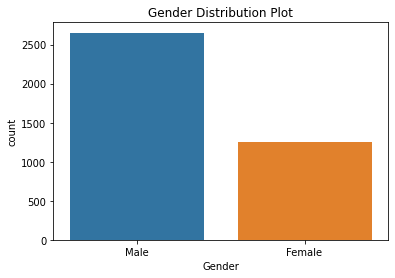

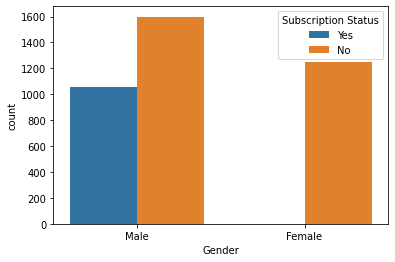

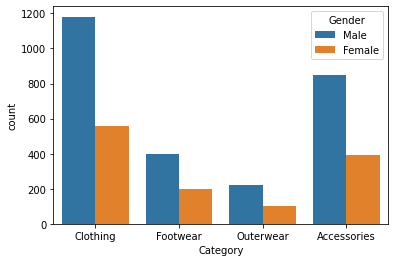

In [150]:
# data visualisation
pd_customer_details = customer_details.toPandas()

# gender count
sns.countplot(data=pd_customer_details, x='Gender') 
plt.title("Gender Distribution Plot") 
  
plt.show()

# gender with subscription status
sns.countplot(data=pd_customer_details, x='Gender', hue='Subscription Status') 
  
plt.show()

# gender with category of purchased items
sns.countplot(data=pd_customer_details, x='Category', hue='Gender') 
  
plt.show()

In [151]:
pd_customer_details.groupby(['Category', 'Gender']).count()['Customer ID']

Category     Gender
Accessories  Female     392
             Male       848
Clothing     Female     556
             Male      1181
Footwear     Female     199
             Male       400
Outerwear    Female     101
             Male       223
Name: Customer ID, dtype: int64

52


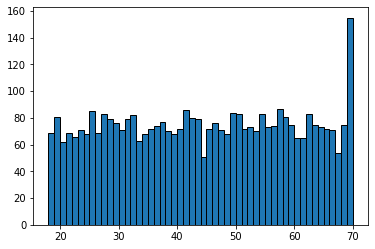

In [152]:
# number of bins
print(pd_customer_details['Age'].max() - pd_customer_details['Age'].min())

# age distribution
plt.hist(data=pd_customer_details, x='Age', edgecolor="black", bins=52) 
  
plt.show()

Discount Applied  Subscription Status
No                No                     2223
Yes               No                      624
                  Yes                    1053
Name: Customer ID, dtype: int64


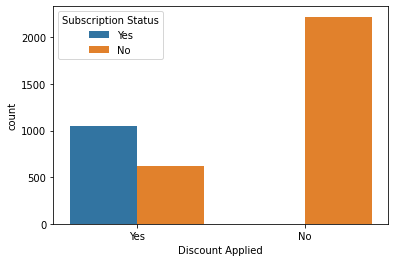

In [153]:
print(pd_customer_details.groupby(['Discount Applied', 'Subscription Status']).count()['Customer ID'])

# discount applied with subscription status
sns.countplot(data=pd_customer_details, x='Discount Applied', hue='Subscription Status') 
  
plt.show()

24/05/23 11:31:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: user id, product id, Interaction type, Time stamp, 
 Schema: user id, product id, Interaction type, Time stamp, _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


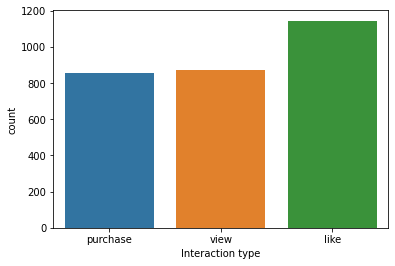

In [154]:
pd_sales_data = sales_data.toPandas()

# interaction type of product
sns.countplot(data=pd_sales_data, x='Interaction type') 
  
plt.show()

### 2.4 Verify Data Quality

In [155]:
# show number of null values in data
print(sales_null)

# show number of rows in sales_data
sales_data.count()

{'user id': 295, 'product id': 295, 'Interaction type': 423, 'Time stamp': 295, '_c4': 3294}


3294

In [156]:
# first 5 rows of interaction type with null values
sales_data.filter("`Interaction type` is null").show(5)

+-------+--------------------+----------------+----------------+----+
|user id|          product id|Interaction type|      Time stamp| _c4|
+-------+--------------------+----------------+----------------+----+
|    276|d49b828318fdd2a55...|            null|23/03/2023 10:00|null|
|    277|90f3d45ebaa97aabd...|            null|24/03/2023 10:00|null|
|    553|693ba00b2a5afe284...|            null| 23/12/2023 8:00|null|
|    908|86927a1ecbd562feb...|            null| 12/11/2023 8:00|null|
|    909|2efb24558840733ca...|            null| 13/11/2023 8:00|null|
+-------+--------------------+----------------+----------------+----+
only showing top 5 rows



24/05/23 11:31:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: user id, product id, Interaction type, Time stamp, 
 Schema: user id, product id, Interaction type, Time stamp, _c4
Expected: _c4 but found: 
CSV file: file:///home/ubuntu/iteration4/E-commerce%20sales%20data%202024.csv


In [157]:
# rows with all null values
sales_data.filter("`user id` is null AND `product id` is null AND `Interaction type` is null AND `Time stamp` is null").count()

295

In [158]:
# show number of null values in data
print(product_null)

# show number of rows in product_details
product_details.count()

{'Uniqe Id': 0, 'Product Name': 0, 'Brand Name': 9567, 'Asin': 9893, 'Category': 1213, 'Upc Ean Code': 9646, 'List Price': 9921, 'Selling Price': 518, 'Quantity': 9669, 'Model Number': 2066, 'About Product': 372, 'Product Specification': 1493, 'Technical Details': 830, 'Shipping Weight': 1091, 'Product Dimensions': 7846, 'Image': 542, 'Variants': 6583, 'Sku': 8742, 'Product Url': 923, 'Stock': 8731, 'Product Details': 9081, 'Dimensions': 9310, 'Color': 9465, 'Ingredients': 9559, 'Direction To Use': 9643, 'Is Amazon Seller': 1583, 'Size Quantity Variant': 9233, 'Product Description': 9456}


10002

In [159]:
product_details.select('Selling Price').show()

+-------------+
|Selling Price|
+-------------+
|      $237.68|
|       $99.95|
|       $34.99|
|       $28.91|
|       $17.49|
|       $18.66|
|       $29.12|
|       $97.68|
|         null|
|       $38.49|
|       $18.16|
|       $84.61|
|       $33.92|
|       $14.99|
|        $4.99|
|       $34.39|
|       $12.88|
|      $117.26|
|        $9.39|
|       $17.85|
+-------------+
only showing top 20 rows



## 3 Data Preparation

### 3.2 Clean Data

In [160]:
# select first 4 columns
sales_data = sales_data.drop('_c4')

# remove rows with any null value
sales_data = sales_data.dropna()

# check if any null value exists
print({col:sales_data.filter(sales_data[col].isNull()).count() for col in sales_data.columns})

# number of rows and number of columns
sales_shape = (sales_data.count(), len(sales_data.columns))
print(sales_shape)

{'user id': 0, 'product id': 0, 'Interaction type': 0, 'Time stamp': 0}
(2871, 4)


In [161]:
# select columns
product_details = product_details.select('Uniqe id', 'Category', 'Is Amazon Seller', 'Selling Price')

# remove rows with any null value
product_details = product_details.dropna()

# check if any null value exists
print({col:product_details.filter(product_details[col].isNull()).count() for col in product_details.columns})

# number of rows and number of columns
product_shape = (product_details.count(), len(product_details.columns))
print(product_shape)

{'Uniqe id': 0, 'Category': 0, 'Is Amazon Seller': 0, 'Selling Price': 0}
(7567, 4)


In [162]:
# selling price values
product_details.select('Selling Price').distinct().show()

+---------------+
|  Selling Price|
+---------------+
|          $9.51|
|         $45.36|
|         $34.91|
|          $1.41|
|         $13.37|
|        $146.87|
|         $36.12|
|         $20.08|
|         $23.93|
|         $32.86|
|$20.93 - $30.93|
|         $19.41|
|          $4.30|
|          $9.97|
|          $5.52|
|          $9.52|
|         $19.03|
|         $50.88|
|         $19.28|
|         $59.97|
+---------------+
only showing top 20 rows



In [163]:
# remove rows contains selling price that defines a range
product_details = product_details.filter(length(col("Selling Price")) <= 10)

# remove dollar signs
product_details = product_details.withColumn("Selling Price", regexp_replace(col("Selling Price"), "\\$", "")\
                                             .cast(DoubleType()))

# selling price values and type
product_details.select('Selling Price').distinct().show()
product_details.printSchema()

+-------------+
|Selling Price|
+-------------+
|        19.98|
|        17.95|
|         14.9|
|         15.5|
|        10.65|
|        40.11|
|         49.8|
|         8.51|
|        76.98|
|        40.53|
|         6.96|
|        24.42|
|        19.27|
|         5.86|
|        16.54|
|        20.49|
|        16.75|
|         5.05|
|        11.53|
|         8.73|
+-------------+
only showing top 20 rows

root
 |-- Uniqe id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Is Amazon Seller: string (nullable = true)
 |-- Selling Price: double (nullable = true)



In [164]:
# select columns
customer_details = customer_details.select('Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', \
                                           'Season', 'Subscription Status', 'Discount Applied')

# check if any null value exists
print({col:customer_details.filter(customer_details[col].isNull()).count() for col in customer_details.columns})

# number of rows and number of columns
customer_shape = (customer_details.count(), len(customer_details.columns))
print(customer_shape)

{'Customer ID': 0, 'Age': 0, 'Gender': 0, 'Item Purchased': 0, 'Category': 0, 'Season': 0, 'Subscription Status': 0, 'Discount Applied': 0}
(3900, 8)


### 3.3 Construct Data

In [186]:
# format time stamp to dd/mm/yyyy hh:mm
def format_timestamp(ts):
    parts = ts.split(" ")
    if len(parts) == 2 and len(parts[1]) != 5:
        return f"{parts[0]} 0{parts[1]}"
    return ts

format_timestamp_udf = udf(format_timestamp, StringType())

# Apply the UDF to the timestamp column
sales_data = sales_data.withColumn("Time stamp", format_timestamp_udf(col("Time stamp")))

# Convert time stamp to a date type
sales_data = sales_data.withColumn("Time stamp", to_timestamp(col("Time stamp"), "dd/MM/yyyy HH:mm"))

# Create day of week variable from time stamp
sales_data = sales_data.withColumn("day_of_week", dayofweek(col("Time stamp")))

# Show the updated DataFrame
sales_data.show()

# Check the schema to ensure the new column is added
sales_data.printSchema()

+-------+--------------------+----------------+-------------------+-----------+
|user id|          product id|Interaction type|         Time stamp|day_of_week|
+-------+--------------------+----------------+-------------------+-----------+
|      1|4c69b61db1fc16e70...|        purchase|2023-10-10 08:00:00|          3|
|      2|66d49bbed043f5be2...|            view|2023-10-11 08:00:00|          4|
|      3|2c55cae269aebf538...|            like|2023-10-12 08:00:00|          5|
|      4|18018b6bc416dab34...|            view|2023-10-13 08:00:00|          6|
|      5|e04b990e95bf73bbe...|            like|2023-10-14 08:00:00|          7|
|      6|f8c32a45e507a1779...|            like|2023-10-15 08:00:00|          1|
|      7|40d3cd16b41970ae6...|        purchase|2023-10-16 08:00:00|          2|
|      8|bc178f33a04dbccef...|            view|2023-10-17 08:00:00|          3|
|      9|cc2083338a16c3fe2...|            like|2023-10-18 08:00:00|          4|
|     10|69828c5570dcdbd16...|        pu

In [193]:
# create season category variable by combining values from season and category
customer_details = customer_details.withColumn("season_category", concat(col("Season"), lit("  "), col("Category")))

customer_details.show()

+-----------+---+------+--------------+-----------+------+-------------------+----------------+-------------------+
|Customer ID|Age|Gender|Item Purchased|   Category|Season|Subscription Status|Discount Applied|    season_category|
+-----------+---+------+--------------+-----------+------+-------------------+----------------+-------------------+
|          1| 55|  Male|        Blouse|   Clothing|Winter|                Yes|             Yes|   Winter  Clothing|
|          2| 19|  Male|       Sweater|   Clothing|Winter|                Yes|             Yes|   Winter  Clothing|
|          3| 50|  Male|         Jeans|   Clothing|Spring|                Yes|             Yes|   Spring  Clothing|
|          4| 21|  Male|       Sandals|   Footwear|Spring|                Yes|             Yes|   Spring  Footwear|
|          5| 45|  Male|        Blouse|   Clothing|Spring|                Yes|             Yes|   Spring  Clothing|
|          6| 46|  Male|      Sneakers|   Footwear|Summer|              

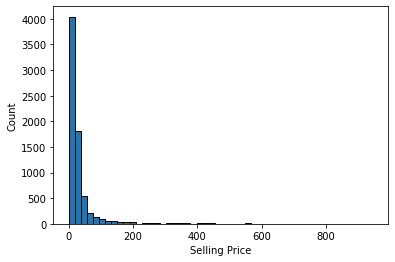

+-------+-----------------+
|summary|    Selling Price|
+-------+-----------------+
|  count|             7224|
|   mean|34.99135520487302|
| stddev|69.01885570629251|
|    min|             0.51|
|    25%|             10.0|
|    50%|            16.99|
|    75%|            29.99|
|    max|           945.99|
+-------+-----------------+

+--------------------+--------------------+----------------+-------------+-----------+
|            Uniqe id|            Category|Is Amazon Seller|Selling Price|Price range|
+--------------------+--------------------+----------------+-------------+-----------+
|4c69b61db1fc16e70...|Sports & Outdoors...|               Y|       237.68|       High|
|66d49bbed043f5be2...|Toys & Games | Le...|               Y|        99.95|       High|
|2c55cae269aebf538...|Toys & Games | Ar...|               Y|        34.99|       High|
|18018b6bc416dab34...|Toys & Games | Ho...|               Y|        28.91|   Moderate|
|e04b990e95bf73bbe...|Toys & Games | Pu...|           

In [194]:
# histogram of selling price
sp_pd = product_details.select('Selling Price').toPandas()
plt.hist(data=sp_pd, x="Selling Price", edgecolor = "black", bins=50)
plt.xlabel("Selling Price")
plt.ylabel("Count")
plt.show()

# selling price summary statistics
product_details.select('Selling Price').summary().show()

# create categories for selling price with low, moderate and high
product_details = product_details.withColumn("Price range", 
    when(col("Selling Price") < 10, "Low")
    .when((col("Selling Price") >= 10) & (col("Selling Price") < 30), "Moderate")
    .otherwise("High")
)

product_details.show()

### 3.4 Integrate Various Data Sources

In [195]:
# Merge customer details and sales data
merged_df = customer_details.join(sales_data, customer_details["Customer ID"] == sales_data["user id"], how='inner')

# merge product details to merged_df
merged_df = merged_df.join(product_details, product_details["Uniqe id"] == merged_df["product id"], how='inner')

# drop duplicate keys
merged_df = merged_df.drop('Uniqe id', 'user id')

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- season_category: string (nullable = true)
 |-- product id: string (nullable = true)
 |-- Interaction type: string (nullable = true)
 |-- Time stamp: timestamp (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Is Amazon Seller: string (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- Price range: string (nullable = false)



### 3.5 Format Data

In [ ]:
# attributes in merged_df
merged_df.printSchema()

## 4 Data Transformation

### 4.1 Reduce Data

### 4.2 Project Data

## 6 Data Mining Algorithm Selection

### 6.3 Build/Select Appropriate Model and Choose Relevant Parameters

## 7 Data Mining

### 7.1 Create and Justify Test Designs

### 7.2 Construct Data Mining

### 7.3 Search for Patterns

## 8 Interpretation